## 0 Set up

This notebook is tested under [python 3.11.\*\*](https://www.python.org/downloads/release/python-368/), and the corresponding packages can be downloaded from [miniconda](https://docs.conda.io/en/latest/miniconda.html). You may also want to get yourself familiar with several packages:

- [jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/)
- [numpy](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [matplotlib](https://matplotlib.org/users/pyplot_tutorial.html)

You can create a python conda environment with the necessary packages using the instructions in the `environment/environment_setup.md` file.

Please implement the functions that have "raise NotImplementedError", and after you finish the coding, please delete or comment "raise NotImplementedError".


In [127]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

from __future__ import absolute_import, division, print_function

%matplotlib inline

import sys

import localtests as localtests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm

print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))

# Load image
import imageio

%load_ext autoreload
%autoreload 2

Version information
python: 3.11.9 (main, Sep 19 2024, 17:13:55) [Clang 15.0.0 (clang-1500.3.9.4)]
matplotlib: 3.9.2
numpy: 1.26.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. KMeans Clustering & DBScan [50pts total: 37pts + 6% Bonus for Undergrad]

KMeans is trying to solve the following optimization problem:

\begin{align}
\arg \min_S \sum_{i=1}^K \sum_{x_j \in S_i} ||x_j - \mu_i||^2
\end{align}
where one needs to partition the N observations into K clusters: $S = \{S_1, S_2, \ldots, S_K\}$ and each cluster has $\mu_i$ as its center.


### 1.1 pairwise distance [5pts]

In this section, you are asked to implement pairwise_dist function.

Given $X \in \mathbb{R}^{N \times D}$ and $Y \in \mathbb{R}^{M \times D}$, obtain the pairwise distance matrix $dist \in \mathbb{R}^{N \times M}$ using the euclidean distance metric, where $dist_{i, j} = ||X_i - Y_j||_2$.

DO NOT USE LOOPS in your implementation, **using for-loops or while-loops will result in 0 credit for this portion.**

**Hint**: Use [array broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), but your implementation shouldn't create a third dimension (which would timeout). This can be achieved by using the $X^2 + Y^2 – 2XY$ shortcut calculation. Also notice that **a numpy array in shape $(N,1)$ is NOT the same as that in shape $(N,)$** so be careful and consistent on what you are using. You can see the detailed explanation here. [Difference between numpy.array shape (R, 1) and (R,)](https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r)

**Hint**: To calculate $X^2$ and $Y^2$ you can refer to the sum of squares function from assignment 1. For detailed explanation of pairwise distance function check this document - https://static.us.edusercontent.com/files/WLtSuk4PzW8e8M6VTsDq0BdJ

We have provided some unit tests in localtests.py for you to check your implementation. See [Using the Local Tests](#using_local_tests) for more details.


In [128]:
localtests.KMeansTests().test_pairwise_dist()
localtests.KMeansTests().test_pairwise_speed()

UnitTest passed successfully!
UnitTest passed successfully!


### 1.2 KMeans Implementation [30pts: 27pts + 1.5% Bonus for Undergrad]

In this section, you are asked to implement several methods in **kmeans.py**

You may use [his visualization tool](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/) to refine your understanding of KMeans.

#### Initialization: [5pts: 2pts + 3pts Bonus for Undergrad]

The Kmeans algorithm is sensitive to how the centers are initialized. The naive approach is to randomly initialize the centers. However, a bad initialization can increase the time required for convergence or may even converge to a non-optimal solution.

- **init_centers** [2pts]: Here you will initialize the centers randomly **(Required for all)**

**Hint**: Please initialize centers by randomly sampling points (without repetition) from the data passed to the KMeans() object upon instantiation in case the autograder fails.

- **kmpp_init** [3pts Bonus for Undergrad]: Here you will use the intuition that points further away from each other will probably be better initial centers by implementing a version of KMeans++ **(Bonus for Undergrad, required for Grads)**

**Hint**: We need to initialize the centers without repetition.

##### KMeans++

The algorithm for KMPP that you will implement can be described as follows:

1. Sample 1% of the points from the dataset, uniformly at random (UAR) and without replacement. This sample will be the dataset the remainder of the algorithm uses to minimize initialization overhead.
2. From the above sample, select only one random point to be the first cluster center.
3. For each point in the sampled dataset, find the nearest cluster center and record the squared distance to get there.
4. Examine all the squared distances and take the point with the maximum squared distance as a new cluster center. In other words, we will choose the next center based on the maximum of the minimum calculated distance instead of sampling randomly like in step 2. You may break ties arbitrarily.
5. Repeat 3-4 until all k-centers have been assigned. You may use a loop over K to keep track of the data in each cluster.

#### Updating Cluster Assignments: [5pts]

After you've chosen your centers, you will need to update the membership of each point based on the closest center.
You will implement this in **update_assignment**. See docstring for more details.

#### Updating Centers Assignments: [5pts]

Since cluster memberships may have changed, you will need to update the cluster centers. You will implement this in **update_centers**. See docstring for more details.

**Hint**: You may use a loop over K to keep track of the data in each cluster. Avoid looping over N individual datapoints.

#### Loss & Convergence [5pts]

We will consider KMeans to be converged when the change in loss drops below a threshold value. The loss will be
defined as the sum of the squared distances between each point and its respective center.


#### Train the model [10pts]

In the **train** method you will use all of the previously implemented steps to train your KMeans algorithm until convergence. Since the centers have already been initialized in the **init** function the general steps for the `train` method is as follows:

1. Update the cluster assignment for each point
2. Update the cluster centers based on the new assignments from Step 1
3. Check to make sure there is no [mean without a cluster](https://www.youtube.com/watch?v=MAU0gQXn28s), i.e. no cluster center without any points assigned to it.
   - In the event of a cluster with no points assigned, pick a random point in the dataset to be the new center and update your cluster assignment accordingly.
4. Calculate the loss and check if the model has converged to break the loop early.
   - The convergence criteria is measured by whether the percentage of difference in loss with respect to the previous iteration's loss is less than the given relative tolerance threshold (self.rel_tol).
5. Iterate through steps 1 to 4 max_iters times. **Make sure to avoid infinite looping.**

We have provided the following local tests to help you check your implementation. Provided unit-tests are meant as a guide and are not intended to be comprehensive. See [Using the Local Tests](#using_local_tests) for more details.


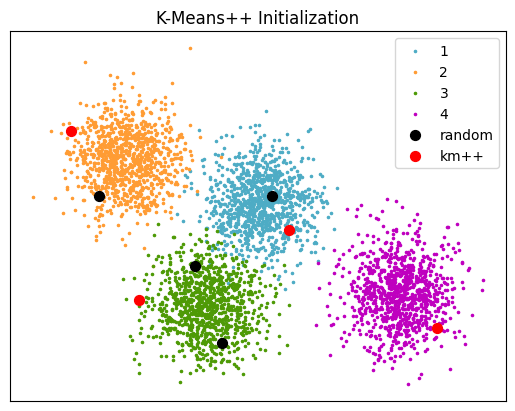

UnitTest passed successfully!
UnitTest passed successfully!


In [129]:
localtests.KMeansTests().test_init()
localtests.KMeansTests().test_update_centers()
localtests.KMeansTests().test_kmeans_loss()

### 1.3 Visualize KMeans [0pts]

Eco Emma, a nature enthusiast and budding data scientist from Green Earth University, is working on a series of eco-friendly posters for an environmental awareness campaign. With her digital resources as scarce as a rare bird sighting, Emma needs to simplify her color palette to reduce file sizes. Recalling her Machine Learning lessons, she knows that KMeans clustering can help distill her vibrant nature images into a more streamlined color palette. Your mission is to assist Emma in transforming this lush forest scene into a minimalist beauty using KMeans to find the optimal palette.

(Artwork generated by [Fotor](https://www.fotor.com/features/ai-image-generator/))

<img src="data/images/mountains.png" width="200">

All you need to do is run the next cell. It should output different paintings of the mountains using different numbers of colors.

Loading...


/Users/chetanreddy.b/Desktop/CS7641/Assignments/HW2/student_files/kmeans.py:62: RuntimeWarning: invalid value encountered in scalar divide
  if abs(prev_loss - self.loss) / prev_loss < self.rel_tol:


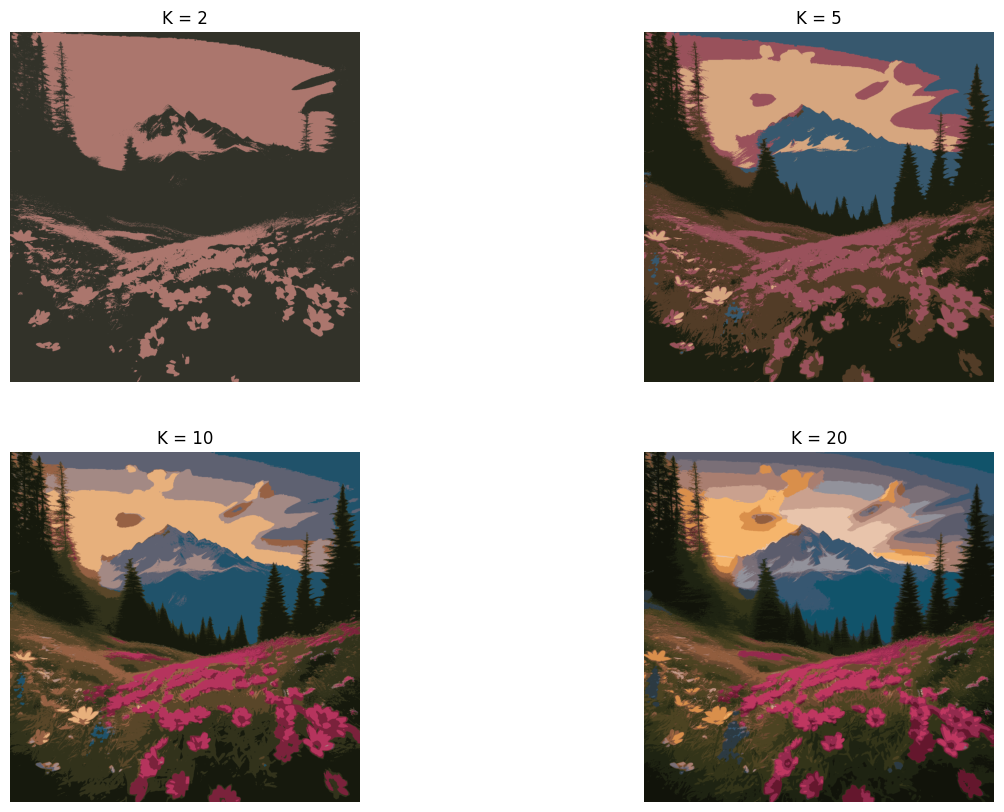

In [130]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

# Note that because of a different file structure, students' paths will be different
from utilities import *

image_values = image_to_matrix("./data/images/mountains.png")

r = image_values.shape[0]
c = image_values.shape[1]
ch = image_values.shape[2]
# flatten the image_values
image_values = image_values.reshape(r * c, ch)

print("Loading...")

image_2 = update_image_values(2, image_values, r, c, ch).reshape(r, c, ch)
image_5 = update_image_values(5, image_values, r, c, ch).reshape(r, c, ch)
image_10 = update_image_values(10, image_values, r, c, ch).reshape(r, c, ch)
image_20 = update_image_values(20, image_values, r, c, ch).reshape(r, c, ch)

plot_image(
    [image_2, image_5, image_10, image_20], ["K = 2", "K = 5", "K = 10", "K = 20"]
)

plt.show()

### 1.4 Fowlkes-Mallow Measure [5pts]

In this section, you will create a function to assess the quality of a clustering algorithm using Fowlkes-Mallow. The Fowlkes-Mallow Measure quantifies the goodness or quality of a clustering algorithm when compared to a ground truth.

As discussed in class, the computation is as follows:
$$FM = \frac{TP}{\sqrt{(TP + FN)(TP + FP)}}$$

TP (True Positive) represents the number of pairs of data points that are correctly clustered together in both the algorithm's result and the ground truth.

TN (True Negative) is the count of pairs of data points that are correctly placed in separate clusters in both the algorithm's result and the ground truth.

FP (False Positive) counts the pairs of data points that are incorrectly clustered together in the algorithm's result but correctly separated in the ground truth.

FN (False Negative) is the number of pairs of data points that are incorrectly separated in the algorithm's result but correctly clustered together in the ground truth.

We have provided the following local tests to help you check your implementation. Provided unit-tests are meant as a guide and are not intended to be comprehensive. See [Using the Local Tests](#using_local_tests) for more details.

**Refer to the class notes for more information on the Fowlkes-Mallow Measure**


In [131]:
localtests.KMeansTests().test_fowlkes_mallow()

Expected value:  0.55745196041636
Your value:  0.55745196041636 

UnitTest passed successfully!


### 1.5 Limitation of K-Means [0pts]

You've now done the best you can selecting the perfect starting points and the right number of clusters. However, one of the limitations of K-Means Clustering is that it depends largely on the shape of the dataset. A common example of this is trying to cluster one circle within another (concentric circles). A K-means classifier will fail to do this and will end up effectively drawing a line that crosses the circles. You can visualize this limitation in the cell below.


/Users/chetanreddy.b/Desktop/CS7641/Assignments/HW2/student_files/kmeans.py:62: RuntimeWarning: invalid value encountered in scalar divide
  if abs(prev_loss - self.loss) / prev_loss < self.rel_tol:


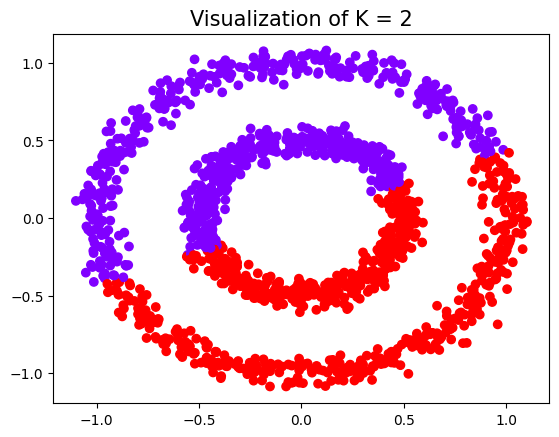

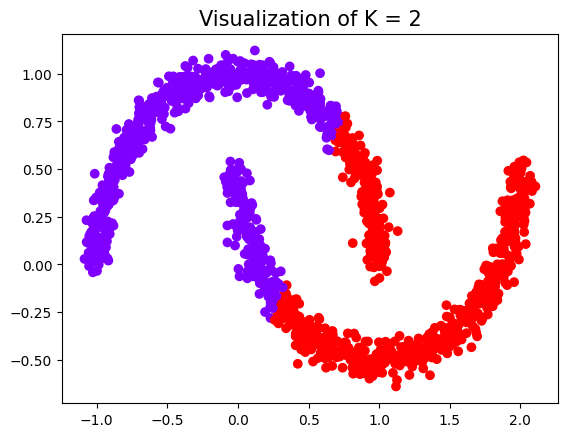

In [132]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

# visualize limitation of kmeans
from kmeans import *
from sklearn.datasets import make_circles, make_moons

X1, y1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)
X2, y2 = make_moons(noise=0.05, n_samples=1500)


def visualise(
    X, C, K=None
):  # Visualization of clustering. You don't need to change this function
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=C, cmap="rainbow")
    if K:
        plt.title("Visualization of K = " + str(K), fontsize=15)
    plt.show()
    pass


kmeans = KMeans(X1, 2)
centers1, cluster_idx1, loss1 = kmeans.train()
visualise(X1, cluster_idx1, 2)
kmeans = KMeans(X2, 2)
centers2, cluster_idx2, loss2 = kmeans.train()
visualise(X2, cluster_idx2, 2)

### 1.6 DBSCAN [10 pts Grad / 4.5% Bonus for Undergrad]

Let us try to solve these limitations using another clustering algorithm: DBSCAN. As mentioned in lecture, DBSCAN tries to find dense regions in the data space, separated by regions of lower density. DBSCAN is parameterized by two parameters (eps and minPts):

- $\epsilon$: Maximum radius of neighborhood
- $MinPts$: Minimum number of points in Eps-neighborhood of a point to be considered "dense".

Note that each cluster is direct density reachable when a point p is within a core point's epsilon neighborhood. Additionally, clusters can contain density reachable points which means that point p is density reachable from point q if there is a chain of points that are directly density reachable.

**Refer to the class slides for the DBSCAN pseudocode** to complete fit(), expandCluster(), and regionQuery() in dbscan.py.

**HINTS:**

- You might find it easier to implement expandCluster() before attempting to implement fit().
- regionQuery() could be used in you implementation of expandCluster()

The following unittests will help get you started, but is in no way comprehensive. You are encouraged to extend and create your own test cases. See [Using the Local Tests](#using_local_tests) for more details.


In [133]:
localtests.DBScanTests().test_region_query()
localtests.DBScanTests().test_expand_cluster()

UnitTest passed successfully!
UnitTest passed successfully!


Then, test your fitting by running the cell below. You should be able to get a perfect clustering for the two circles dataset, which you can observe quantitatively by checking whether the clusters returned by cluster_idx and the ground truth clusters are the same and qualitatively by visualizing the clusters.


/Users/chetanreddy.b/Desktop/CS7641/Assignments/HW2/student_files/kmeans.py:72: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(dist_sq)


True
False


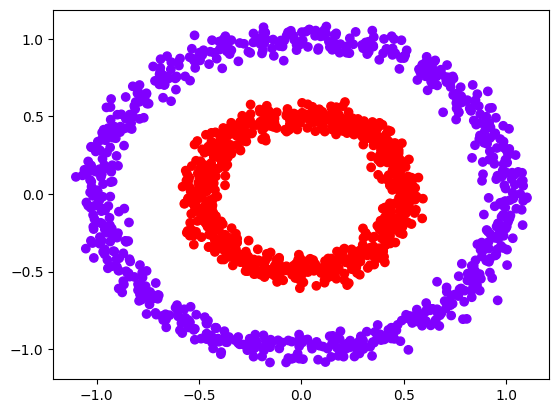

In [134]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

BEST_EPS = 0.11
BEST_POINTS = 3
from dbscan import DBSCAN

dbscan = DBSCAN(BEST_EPS, BEST_POINTS, X1)
cluster_idx = dbscan.fit()
## Note that one of the two cells should print True for a correct implementation
print(np.array_equal(y1, cluster_idx))  # Checks if y1 == cluster_idx
print(
    np.array_equal(y1, 1 - cluster_idx)
)  ## Checks if y1 is the exact opposite of cluster_idx (1s instead of 0s and vice-versa)
visualise(X1, cluster_idx)

# 2. EM algorithm [15pts + 1% Bonus for All]


### 2.1 Performing EM Update [15 pts]

**ANSWERS CANNOT BE HANDWRITTEN**

A univariate Gaussian Mixture Model (GMM) has two components, both of which have their own mean and standard deviation. The model is defined by the following parameters:
$$ \mathbf{z} \sim Bernoulli(\alpha) = \begin{cases} \alpha &\text{if} \, z=0 \\ 1-\alpha &\text{if} \, z=1 \\\end{cases}$$
$$ p\left(\mathbf{x_n \mid z=0}\right) \sim \mathcal{N}(3\upsilon, 8\omega^{2}) $$
$$ p\left(\mathbf{x_n \mid z=1}\right) \sim \mathcal{N}(2\upsilon, 7\omega^{2}) $$

For a dataset of N datapoints, find the following:

2.1.1. Write the marginal probability of x, i.e. $p(x)$ \[3pts]
<br> -- Express your answers in terms of $\mathcal{N}(x|3\upsilon, 8\omega^{2})$ and $\mathcal{N}(x|2\upsilon, 7\omega^{2})$ may be simpler
<br> -- HINT: For this question suppose we have a Gaussian Distribution $\mathcal{N}(2\upsilon, 7\omega^{2})$, it means $\mathcal{N}(\mu = 2\upsilon, \sigma^{2} = 7\omega^{2})$
<br> -- HINT: Start with the Sum Rule


2.1.2. E-Step: Compute the posterior probabilities, i.e, $p(z_0|x), p(z_1|x)$ \[3pts]
<br> -- Express your answers in terms of $\mathcal{N}(3\upsilon, 8\omega^{2})$ and $\mathcal{N}(2\upsilon, 7\omega^{2})$
<br> -- HINT: Try to apply Bayes Rule

2.1.3. M-Step: Compute the updated value of $\omega^{2}$. (You can keep $\mu$ fixed when you calculate the derivative.) \[9pts]
<br> -- Note that $\omega^2$ is a shared variable between the two distributions, your final answer should be one equation including both Gaussian distributions
<br> -- Express your answers in terms of $\tau$, $x$, and $\upsilon$ (you will need to expand $\mathcal{N}(3\upsilon, 8\omega^{2})$ and $\mathcal{N}(2\upsilon, 7\omega^{2})$ into its PDF form)
<br> -- HINT: Start from the below equation, note that $\theta$ is shorthand for various variables, and take the derivative w.r.t. $\omega^2$

$$
\begin{align*}
\ell(\theta|x) &= \sum^{N} \sum^{Z}_{k \in \{0, 1\}}p(z_k|x_n,\theta_{old})ln \left[p(x_n,z_k|\theta)\right]\\
\ell(\upsilon, \omega^2, \alpha \mid x)
&= \sum^{N} \sum^{Z}_{k \in \{0, 1\}} p(z_k \mid x_n, \theta_{old}) \ln\left[p(x_n, z_k \mid \mu_k, \sigma^2_k, \alpha)\right] \\
&=  \sum^{N} \sum^{Z}_{k \in \{0, 1\}} p(z_k \mid x_n, \theta_{old}) \ln \left[p(z_k \mid \alpha) p(x_n \mid z_k, \upsilon, \omega^2)\right]
\end{align*}
$$

Recall that $p(x_n \mid z_k, \upsilon, \omega^2) \rightarrow \mathcal{N}(x_n \mid \mu_k, \sigma_k)$ has been defined at the beginning of the problem.

You can refer to this lecture to gain an understanding of the EM Algorithm. For your convenience, I have included the link below:

https://mahdi-roozbahani.github.io/CS46417641-fall2024/course/09-gaussian-mixture.pdf

### 2.1.1. Marginal Probability of \(x\) 

The marginal probability \(p(x)\) can be computed by applying the sum rule, which considers both possible states of the latent variable \(z\):
$$ p(x) = p(x \mid z=0) \cdot p(z=0) + p(x \mid z=1) \cdot p(z=1) $$
Substituting the values from the problem statement:
$$ p(x) = \alpha \cdot \mathcal{N}(x \mid 3\upsilon, 8\omega^2) + (1-\alpha) \cdot \mathcal{N}(x \mid 2\upsilon, 7\omega^2) $$



### 2.1.2. E-Step: Posterior Probabilities 
In the E-step of the EM algorithm, we compute the posterior probabilities $p(z_0 \mid x)$ and $p(z_1 \mid x)$ using Bayes' rule.

For $p(z_0 \mid x)$:
$$ p(z_0 \mid x) = \frac{p(z_0) \cdot p(x \mid z_0)}{p(x)} $$
Substituting in the expressions for $p(z_0)$ and $p(x)$:
$$ p(z_0 \mid x) = \frac{\alpha \cdot \mathcal{N}(x \mid 3\upsilon, 8\omega^2)}{\alpha \cdot \mathcal{N}(x \mid 3\upsilon, 8\omega^2) + (1-\alpha) \cdot \mathcal{N}(x \mid 2\upsilon, 7\omega^2)} $$

Similarly, for $p(z_1 \mid x)$:
$$ p(z_1 \mid x) = \frac{p(z_1) \cdot p(x \mid z_1)}{p(x)} $$
Substituting the corresponding terms:
$$ p(z_1 \mid x) = \frac{(1-\alpha) \cdot \mathcal{N}(x \mid 2\upsilon, 7\omega^2)}{\alpha \cdot \mathcal{N}(x \mid 3\upsilon, 8\omega^2) + (1-\alpha) \cdot \mathcal{N}(x \mid 2\upsilon, 7\omega^2)} $$


### 2.1.3. M-Step: Updating $\omega^2$

In the M-step of the EM algorithm, the objective is to maximize the expected complete-data log-likelihood with respect to the parameter $\omega^2$. The log-likelihood function for a Gaussian Mixture Model (GMM) is given by:

$$
\ell(\theta \mid x) = \sum_{n=1}^{N} \sum_{k \in \{0, 1\}} p(z_k \mid x_n, \theta_{\text{old}}) \ln \left[p(z_k \mid \alpha) p(x_n \mid z_k, \upsilon, \omega^2)\right]
$$

Here, $\theta = (\upsilon, \omega^2, \alpha)$ are the parameters to be updated. In this case, we will focus on updating $\omega^2$ and only consider the terms that involve $\omega^2$. For each component $k$, the likelihood of a data point $x_n$ given the component $z_k$ is:

$$
p(x_n \mid z_k) = \mathcal{N}(x_n \mid \mu_k, \sigma_k^2)
$$

where $\mu_k$ and $\sigma_k^2$ are the mean and variance of the Gaussian component $k$. Using $p(z_k \mid x_n, \theta_{\text{old}}) = \tau_k$, which is the posterior probability of component $k$, we can now expand the log-likelihood for the two components $k=0$ and $k=1$.

The expanded log-likelihood function becomes:

$$
\ell(\theta \mid x) = \sum_{n=1}^{N} \left[ \tau_0 \ln \left( \frac{\alpha}{\sqrt{16\pi\omega^2}} \exp\left(-\frac{(x_n - 3\upsilon)^2}{16\omega^2}\right) \right) + \tau_1 \ln \left( \frac{1-\alpha}{\sqrt{14\pi\omega^2}} \exp\left(-\frac{(x_n - 2\upsilon)^2}{14\omega^2}\right) \right) \right]
$$

### Simplifying the Log-Likelihood

We can now break down the log-likelihood by separating the constant terms from the parts that involve $\omega^2$. The logarithmic expression can be expanded as follows:

For $\tau_0$:

$$
\tau_0 \ln \left( \frac{\alpha}{\sqrt{16\pi\omega^2}} \exp\left(-\frac{(x_n - 3\upsilon)^2}{16\omega^2}\right) \right) = \tau_0 \left[ \ln \left( \frac{\alpha}{\sqrt{16\pi\omega^2}} \right) + \ln \left( \exp \left( - \frac{(x_n - 3\upsilon)^2}{16 \omega^2} \right) \right) \right]
$$

The logarithm of the exponential simplifies:

$$
\tau_0 \ln \left( \frac{\alpha}{\sqrt{16\pi\omega^2}} \exp\left(-\frac{(x_n - 3\upsilon)^2}{16\omega^2}\right) \right) = \tau_0 \left[ \ln \left( \frac{\alpha}{\sqrt{16\pi\omega^2}} \right) - \frac{(x_n - 3\upsilon)^2}{16 \omega^2} \right]
$$

Similarly, for $\tau_1$:

$$
\tau_1 \ln \left( \frac{1-\alpha}{\sqrt{14\pi\omega^2}} \exp\left(-\frac{(x_n - 2\upsilon)^2}{14\omega^2}\right) \right) = \tau_1 \left[ \ln \left( \frac{1-\alpha}{\sqrt{14\pi\omega^2}} \right) - \frac{(x_n - 2\upsilon)^2}{14 \omega^2} \right]
$$

### Combining Terms

Now, we can simplify the log-likelihood function by combining the terms that involve $\omega^2$:

$$
\ell(\theta \mid x) = \sum_{n=1}^{N} \left[ \frac{-1}{2} \ln (\omega^2) - \frac{\tau_0 (x_n - 3\upsilon)^2}{16 \omega^2} - \frac{\tau_1 (x_n - 2\upsilon)^2}{14 \omega^2} \right] + C
$$

Where $C$ represents the constant terms that do not depend on $\omega^2$.

### Deriving the Optimal $\omega^2$

To maximize the log-likelihood with respect to $\omega^2$, we take the derivative of $\ell(\theta \mid x)$ with respect to $\omega^2$ and set it to zero:

$$
\frac{d\ell(\theta \mid x)}{d\omega^2} = \sum_{n=1}^{N} \left[ \frac{-1}{2\omega^2} + \frac{\tau_0 (x_n - 3\upsilon)^2}{16 \omega^4} + \frac{\tau_1 (x_n - 2\upsilon)^2}{14 \omega^4} \right] = 0
$$

Rearranging the terms gives:

$$
\frac{N}{2\omega^2} = \sum_{n=1}^{N} \left[ \frac{\tau_0 (x_n - 3\upsilon)^2}{16 \omega^4} + \frac{\tau_1 (x_n - 2\upsilon)^2}{14 \omega^4} \right]
$$

Finally, solving for $\omega^2$:

$$
\omega^2 = \frac{1}{N} \sum_{n=1}^{N} \left[ \frac{\tau_0 (x_n - 3\upsilon)^2}{8} + \frac{\tau_1 (x_n - 2\upsilon)^2}{7} \right]
$$

### Conclusion

This equation provides the updated estimate for $\omega^2$, the shared variance parameter across the two components of the Gaussian Mixture Model (GMM). The update step uses both the posterior probabilities $\tau_0$ and $\tau_1$ (calculated in the E-step) and the squared differences between the observed data points and the means of each component.


### 2.2 Gradient Ascent and EM algorithm [1% Bonus for All]


2.2. What is the computational advantage of using the EM algorithm compared to the Gradient Ascent algorithm for the problem presented in 2.1? Please provide your own qualitative analysis. [5pts]
<br> -- HINT: Think about the difference in updating parameters during each iteration. i.e. How many parameters need to be updated in gradient descent? What we did in for each iteration in EM algorithm to simplify it? 


### 2.2. Computational Advantage of EM Algorithm Over Gradient Ascent

In the context of the problem described in 2.1, if we were to use the Gradient Ascent algorithm, we would need to update the parameters $\upsilon$, $\omega$, and $\alpha$ by calculating their respective gradients with respect to the log-likelihood function $\ell(\theta \mid x)$. 

The key challenge with using Gradient Ascent for this problem is that the log-likelihood function involves a sum of two Gaussian distributions. Specifically, we are dealing with:

$$ \ell(\theta \mid x) = \ln \left( \alpha \cdot \mathcal{N}(x \mid 3\upsilon, 8\omega^2) + (1 - \alpha) \cdot \mathcal{N}(x \mid 2\upsilon, 7\omega^2) \right) $$

Since this function involves the **logarithm of a sum**, calculating the gradient becomes more complex. Differentiating a log-sum is not straightforward, because it introduces terms that are not easily separable. As a result, each gradient calculation for $\upsilon$, $\omega^2$, and $\alpha$ becomes significantly more computationally expensive. Furthermore, the log-sum structure can make the objective function **non-concave**, which adds another layer of difficulty. Non-concave functions often have multiple local maxima, making it harder to guarantee convergence to the global maximum, and it might require careful tuning of the learning rate and other hyperparameters in Gradient Ascent.

In contrast, the **Expectation-Maximization (EM) algorithm** provides a more efficient and structured approach to solving this problem. 

#### How the EM Algorithm Simplifies the Process

1. **E-step (Expectation Step)**: 
   - In the E-step, we calculate the posterior probabilities, or **responsibilities**, denoted by $\tau_k$. These responsibilities represent the probability that each data point belongs to each component (i.e., Gaussian distribution) based on the current estimates of the parameters. 
   - Importantly, this step involves using **Bayes' theorem** to compute these probabilities, and it avoids the need to calculate gradients altogether. The posterior probabilities are computed directly, and there is no need to perform the complex differentiation of the log-likelihood function.

2. **M-step (Maximization Step)**: 
   - In the M-step, we update the parameters $\upsilon$, $\omega^2$, and $\alpha$ using closed-form expressions that are derived from the responsibilities computed in the E-step. These updates are **direct** and do not involve gradients.
   - For example, the parameter $\omega^2$ is updated based on the following formula:
   
     $$
     \omega^2 = \frac{1}{N} \sum_{n=1}^{N} \left[ \frac{\tau_0 (x_n - 3\upsilon)^2}{8} + \frac{\tau_1 (x_n - 2\upsilon)^2}{7} \right]
     $$

   - This closed-form update eliminates the need to differentiate the log-likelihood function, simplifying the update process significantly.

#### Key Computational Advantages of EM Over Gradient Ascent:

- **No Gradients**: 
  - In the EM algorithm, there is no need to compute gradients, which are often computationally expensive, especially for functions involving sums of Gaussians. The EM algorithm avoids this complexity by breaking the problem into simpler subproblems. The parameter updates in the M-step are derived analytically, making them easy to compute.

- **Handling the Log-Sum**: 
  - The EM algorithm handles the **logarithm of a sum** indirectly through the E-step, where the posterior probabilities are computed. These probabilities are then used in the M-step, where the parameter updates are performed in a more straightforward manner. This contrasts with Gradient Ascent, where you would need to differentiate the log-sum directly, making the update step more involved and prone to numerical instability.

- **Avoiding Non-Concavity Issues**: 
  - In Gradient Ascent, the non-concave nature of the log-likelihood function can lead to difficulties in convergence. The EM algorithm avoids this by breaking the process into two steps: in the E-step, the current estimates of the parameters are used to compute the posterior probabilities, and in the M-step, the parameters are updated based on those probabilities. This process ensures smooth updates and helps avoid issues like getting stuck in local maxima.

- **Closed-Form Updates**: 
  - In the M-step, the updates for the parameters are **closed-form solutions** rather than iterative gradient-based updates. This reduces computational overhead since the updates can be computed directly without having to iterate or tune learning rates.

#### Conclusion:

Overall, the EM algorithm provides a more computationally efficient alternative to Gradient Ascent for the problem at hand. It simplifies the update process by breaking the optimization into two distinct steps (E-step and M-step), each of which is easier to compute than the gradient-based updates required by Gradient Ascent. The EM algorithm thus avoids the challenges posed by the log-sum structure of the log-likelihood and achieves faster, more stable convergence.



## 3. GMM implementation [65pts total: 60pts + 1% Bonus for All]

**Please make sure to read the problem setup in detail. Many questions for this section may have already been answered in the description and hints and docstrings.**

A Gaussian Mixture Model (GMM) is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian Distribution. In a nutshell, GMM is a soft clustering algorithm in a sense that each data point is assigned to a cluster with a probability. In order to do that, we need to convert our clustering problem into an inference problem.

Given $N$ samples $X = [x_1, x_2, \ldots, x_N]^T$, where $x_i \in \mathbb{R}^D$. Let $\pi$ be a K-dimensional probability density function and $(\mu_k; \Sigma_k)$ be the mean and covariance matrix of the $k^{th}$ Gaussian distribution in $\mathbb{R}^d$.

The GMM object implements EM algorithms for fitting the model and MLE for optimizing its parameters. It also has some particular hypothesis on how the data was generated:

- Each data point $x_i$ is assigned to a cluster $k$ with probability of $\pi_k$ where $\sum_{k=1}^K \pi_k = 1$
- Each data point $x_i$ is generated from Multivariate Normal Distribution $\cal{N}(\mu_k, \Sigma_k)$ where $\mu_k \in \mathbb{R}^D$ and $\Sigma_k \in \mathbb{R}^{D\times D}$

Our goal is to find a $K$-dimension Gaussian distributions to model our data $X$. This can be done by learning the parameters $\pi, \mu$ and $\Sigma$ through likelihood function. Detailed derivation can be found in our slide of GMM. The log-likelihood function now becomes:

\begin{align}
\text{ln } p(x_1, \dots, x_N | \pi, \mu, \Sigma) = \sum_{i=1}^N \text{ln } \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)\big)
\end{align}


From the lecture we know that MLEs for GMM all depend on each other and the responsibility $\tau$. Thus, we need to use an iterative algorithm (the EM algorithm) to find the estimate of parameters that maximize our likelihood function. **All detailed derivations can be found in the lecture slide of GMM.**

- **E-step:** Evaluate the responsibilities

In this step, we need to calculate the responsibility $\tau$, which is the conditional probability that a data point belongs to a specific cluster $k$ if we are given the datapoint, i.e. $P(z_k|x)$. The formula for $\tau$ is given below:

$$
\tau\left(z_k\right)=\frac{\pi_{k} \cal{N}\left(x | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \cal{N}\left(x | \mu_{j}, \Sigma_{j}\right)}, \quad \text{for } k = 1, \dots, K
$$

Note that each data point should have one probability for each component/cluster. For this homework, you will work with $\tau\left(z_k\right)$ which has a size of $N\times K$ and you should have all the responsibility values in one matrix.

- **M-step:** Re-estimate Paramaters

After we obtained the responsibility, we can find the update of parameters, which are given below:

\begin{align}
\mu_k^{new} &= \dfrac{\sum_{n=1}^N \tau(z_k)x_n}{N_k} \\
\Sigma_k^{new} &= \dfrac{1}{N_k}\sum_{n=1}^N \tau (z_k)^T(x_n - \mu_k^{new})^T(x_n-\mu_k^{new}) \\
\pi_k^{new} &= \dfrac{N_k}{N}
\end{align}
where $N_k = \sum_{n=1}^N \tau(z_k)$. Note that the updated value for $\mu_k$ is used when updating $\Sigma_k$. The multiplication of $\tau (z_k)^T(x_n - \mu_k^{new})^T$ is element-wise so it will preserve the dimensions of $(x_n - \mu_k^{new})^T$.

- We repeat E and M steps until the incremental improvement to the likelihood function is small.


**Special Notes**

- For undergraduate student: you may assume that the covariance matrix $\Sigma$ is diagonal matrix, which means the features are independent. (i.e. the red intensity of a pixel is independent from its blue intensity, etc). Make sure you set **FULL_MATRIX = False** before you submit your code to Gradescope.
- For graduate student: please assume full covariance matrix. Make sure you set **FULL_MATRIX = True** before you submit your code to Gradescope
- The class notes assume that your dataset $X$ is $(D, N)$ but **the homework dataset is $(N, D)$ as mentioned on the instructions, so the formula is a little different from the lecture note in order to obtain the right dimensions of parameters.**

**Hints**

1. **DO NOT USE FOR LOOPS OVER N.** You can always find a way to avoid looping over the observation datapoints in our homework problem. If you have to loop over D or K, that is fine.

2. You can initiate $\pi(k)$ the same for each $k$, i.e. $\pi(k) = \frac{1}{K}, \forall k = 1, 2, \ldots, K$.

3. In part 3 you are asked to generate the model for pixel clustering of image. We will need to use a multivariate Gaussian because each image will hava $N$ pixels and $D=3$ features which corresponds to red, green, and blue color intensities. It means that each image is a $(N\times3)$ dataset matrix. In the following parts, remember $D=3$ in this problem.

4. To avoid using for loops in your code, we recommend you take a look at the concept [Array Broadcasting in Numpy](https://numpy.org/doc/stable/user/basics.broadcasting.html). Also, certain calculations that required different shapes of arrays can also be achieved by broadcasting.

5. Be careful of the dimensions of your parameters. Before you test anything on the autograder, please look at the instructions below on the shapes of the variables you need to output and how to format your return statement. Print the shape of an array by [print(array.shape)](https://www.w3schools.com/python/numpy/numpy_array_shape.asp) could enhance the functionality of your code and help you debugging. Also notice that **a numpy array in shape $(N,1)$ is NOT the same as that in shape $(N,)$** so be careful and consistent on what you are using. You can see the detailed explanation here. [Difference between numpy.array shape (R, 1) and (R,)](https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r)

- The dataset $X$: $(N, D)$
- $\mu$: $(K, D)$.
- $\Sigma$: $(K, D, D)$
- $\tau$: $(N, K)$
- $\pi$: array of length $K$
- ll_joint: $(N, K)$


## 3.1 Helper functions [15pts]

To facilitate some of the operations in the GMM implementation, we would like you to implement the following three helper functions. In these functions, "logit" refers to an input array of size $(N, D)$ that reperesents the unnormalized scores, that are passed to the softmax( ) or logsumexp( ) function. Remember the goal of helper functions is to facilitate our calculation so **DO NOT USE FOR LOOP OVER N**.

### 3.1.1. softmax [5pts]

Given $logit \in \mathbb{R}^{N \times D}$, calculate $prob \in \mathbb{R}^{N \times D}$, where $prob_{i, j} = \frac{\exp(logit_{i, j})}{\sum_{d=1}^D exp(logit_{i, d})}$.

Notes:

- $logit$ here refers to the unnormalized scores that are passed in as a parameter to the softmax function. The softmax operation normalizes these scores, resulting in them having values between 0 and 1. This allows us to interpret the normalized scores as a probability distribution over the classes.
- It is possible that $logit_{i, j}$ is very large, making $\exp(\cdot)$ of it to explode. To make sure it is numerically stable, for each row of $logits$ subtract the maximum of that row.
  - By property of Softmax equation, subtracting a constant value does not change the output. [Refer to Mathematical properties](https://en.wikipedia.org/wiki/Softmax_function#Mathematical_properties)
  - For an intuitive understanding on why this helps us, consider plotting $e^{-x}$ and $e^x$ on a graphing calculator when $x \geq 0$

**Special Notes**

- Do not add back the maximum for each row.
- Add **keepdims=True** in your np.sum() function to avoid broadcast error.

### 3.1.2. logsumexp [3pts Programming + 2pts Written Questions]

Given $logit \in \mathbb{R}^{N \times D}$, calculate $s \in \mathbb{R}^N$, where $s_i = \log \big( \sum_{j=1}^D \exp(logit_{i, j}) \big)$. Again, pay attention to the numerical problem. You may face similar conditions to the softmax function due to $logit_{i, j}$ being large. Therefore, you should add the maximum for each row of $logit$ back for your functions before returning the final value. 

**Special Notes**

- This function is used in the call() function, which is given, and helps calculate the loss of log-likelihood. You will not have to call it in functions that you are required to implement.


#### Written Questions [2pts]:

1. Why should we add the maximum for each row of $logit$ to **logsumexp()** function? Show your reason by calculating and observing the relationship between $F$ and $s_1$.
   <br> -- Use a simple input like $logit \in \mathbb{R}^{1 \times 3}$ and work through a mathematical example.
   <br> -- Let N=1, D=3, $logit = \{ logit_{11},logit_{12}, logit_{13} \} $ and $max = logit_{13}$ is the maximum for this row. $F$ is the array that subtracts the maximum for each row of $logits$.
   <br> -- Start by subtracting the max of the row from each element in $s_1 = \log \big( \sum_{j=1}^D \exp(logit_{1, j}) \big)$


Logit values be $\{a, b, c\}$, where the maximum value in the set is $m = \max(a, b, c)$.

We start by subtracting the maximum value $m$ from each element of the logit array. The resulting array after subtraction is:

$$
\text{logit}_{\text{sub}} = \{a - m, b - m, c - m\}
$$

Now, we apply the **logsumexp()** function to this adjusted array. The expression for the log-sum-exp becomes:

$$
\text{value}_{\text{sub}} = \log \left( \exp(a - m) + \exp(b - m) + \exp(c - m) \right)
$$

Next, we factor out $\exp(-m)$ from the sum inside the logarithm:

$$
\text{value}_{\text{sub}} = \log \left( \frac{\exp(a) + \exp(b) + \exp(c)}{\exp(m)} \right)
$$

This simplifies to:

$$
\text{value}_{\text{sub}} = \log \left( \exp(a) + \exp(b) + \exp(c) \right) - m
$$

Thus, we can see that:

$$
\text{value}_{\text{sub}} = \text{value} - m
$$

Where $\text{value}$ is the result of applying the **logsumexp()** function to the original, unadjusted logit values:

$$
\text{value} = \log \left( \exp(a) + \exp(b) + \exp(c) \right)
$$

### Conclusion:

Therefore, to retrieve the actual desired $\text{value}$ after subtracting the maximum $m = \max(a, b, c)$, we need to add back the value of $m$. This gives the correct result for **logsumexp()**:

$$
\log \left( \exp(a - m) + \exp(b - m) + \exp(c - m) \right) + m
$$

### Example for logsumexp() with a simple input:

Let the logit values be $\{a, b, c\} = \{2, 4, 6\}$, where the maximum value is $m = \max(a, b, c) = 6$.

We start by subtracting the maximum value $m$ from each element of the logit array. The resulting array after subtraction is:

$$
\text{logit}_{\text{sub}} = \{2 - 6, 4 - 6, 6 - 6\} = \{-4, -2, 0\}
$$

Now, we apply the **logsumexp()** function to this adjusted array. The expression for the log-sum-exp becomes:

$$
\text{value}_{\text{sub}} = \log \left( \exp(-4) + \exp(-2) + \exp(0) \right)
$$

Calculating the individual exponentials:

$$
\exp(-4) \approx 0.0183, \quad \exp(-2) \approx 0.1353, \quad \exp(0) = 1
$$

Thus, we have:

$$
\text{value}_{\text{sub}} = \log \left( 0.0183 + 0.1353 + 1 \right) = \log(1.1536) \approx 0.143
$$

Next, to retrieve the actual desired value, we need to add back the maximum value $m = 6$. Therefore, the final result is:

$$
\text{value} = 0.143 + 6 = 6.143
$$

For comparison, if we directly calculate **logsumexp** without adjusting by subtracting $m$:

$$
\text{value} = \log \left( \exp(2) + \exp(4) + \exp(6) \right)
$$

Calculating the exponentials:

$$
\exp(2) \approx 7.389, \quad \exp(4) \approx 54.598, \quad \exp(6) \approx 403.429
$$

Thus, we get:

$$
\text{value} = \log \left( 7.389 + 54.598 + 403.429 \right) = \log(465.416) \approx 6.143
$$

### Conclusion:

Both methods give the same final result, $\text{value} \approx 6.143$. By subtracting the maximum value first and then adding it back, we avoid numerical instability caused by large exponentials. This technique ensures the calculation is stable while preserving the correct result.


### 3.1.3. Multivariate Gaussian PDF [5pts]

You should be able to write your own function based on the following formula, and you are **NOT allowed** to use outside resource packages other than those we provided.

**(for undergrads only) normalPDF**

Using the covariance matrix as a diagonal matrix with variances of the individual variables appearing on the main diagonal of the matrix and zeros everywhere else means that we assume the features are independent. In this case, the multivariate normal density function simplifies to the expression below:
$$\mathcal{N}(x: \mu, \Sigma) = \prod_{i=1}^D \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left( -\frac{1}{2\sigma_i^2} (x_i-\mu_i)^2\right)}$$
where $\sigma^2_i$ is the variance for the $i^{th}$ feature, which is the diagonal element of the covariance matrix.

**(for grads only) multinormalPDF**

Given the dataset $X \in \mathbb{R}^{N \times D}$, the mean vector $\mu \in \mathbb{R}^{D}$ and covariance matrix $\Sigma \in \mathbb{R}^{D \times D}$ for a multivariate Gaussian distrubution, calculate the probability $p \in \mathbb{R}^{N}$ of each data. The PDF is given by
$$\mathcal{N}(X: \mu, \Sigma) = \frac{1}{(2\pi)^{D/2}}|\Sigma|^{-1/2}\exp{\left(-\frac{1}{2}(X-\mu)\Sigma^{-1}(X-\mu)^T\right)}$$
where $|\Sigma|$ is the determinant of the covariance matrix.

**Hints:**

- If you encounter "LinAlgError", you can mitigate your number/array by summing a small value before taking the operation, e.g. np.linalg.inv($\Sigma_k$ + SIGMA_CONST). You can arrest and handle such error by using [Try and Exception Block](https://realpython.com/python-exceptions/#the-try-and-except-block-handling-exceptions) in Python. Please only add `SIGMA_CONST` to all elements when `sigma_i` is not invertible.

- In the above calculation, you must avoid computing a $(N,N)$ matrix. Using the above equation for large N will crash your kernel and/or give you a memory error on Gradescope. Instead, you can do this same operation by calculating $(X-\mu)\Sigma^{-1}$, a $(N,D)$ matrix, transpose it to be a $(D,N)$ matrix and do an element-wise multiplication with $(X-\mu)^T$, which is also a $(D,N)$ matrix. Lastly, you will need to sum over the 0 axis to get a $(1,N)$ matrix before proceeding with the rest of the calculation. This uses the fact that doing an element-wise multiplication and summing over the 0 axis is the same as taking the diagonal of the $(N,N)$ matrix from the matrix multiplication.

- In Numpy implementation for each individual $\mu$, you can either use a 2-D array with dimension $(1,D)$ for each Gaussian Distribution, or a 1-D array with length $D$. Same to other array parameters. Both ways should be acceptable but pay attention to the shape mismatch problem and be **consistent all the time** when you implement such arrays.

- Please **DO NOT** use `self.D` in your implementation of `multinormalPDF()` .


### 3.2 GMM Implementation [30pts]


Things to do in this problem:

### 3.2.1. Initialize parameters in \_init_components() [5pts]

Examples of how you can initialize the parameters.

1. `create_pi()`: Set the prior probability $\pi$ the same for each class.
2. `create_mu()`: Initialize $\mu$ by randomly selecting K numbers of observations as the initial mean vectors. You can use [int(np.random.uniform())](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to get the row index number of the datapoints randomly.
3. `create_sigma()`: Initialize the covariance matrix with [np.eye()](https://numpy.org/devdocs/reference/generated/numpy.eye.html) for each k. For grads, you can also initialize the $\Sigma$ by K diagonal matrices. It will become a full matrix after one iteration, as long as you adopt the correct computation.
4. You are expected to call these methods in the `_init_components()` method
5. The autograder will only test the shape of your $\pi$,$\mu$, $\sigma$. Make sure you pass other evaluations in the autograder.

### 3.2.2. Formulate the log-likelihood function \_ll_joint() [10pts]

The log-likelihood function is given by:

$$
\begin{align}
    \ell(\theta) = \sum_{i=1}^N \text{ln } \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)\big)
\end{align}
$$

In this part, we will generate a $(N,K)$ matrix where each datapoint $x_i, \forall i = 1, \dots, N$ has $K$ log-likelihood numbers. Thus, for each $i = 1, \dots, N$ and $k = 1, \dots, K$,

$$
\text{log-likelihood}[i,k] = \log{\pi_k}+\log{\cal{N}(x_i|\mu_k, \Sigma_k)}
$$

**Hints:**

- If you encounter "ZeroDivisionError" or "RuntimeWarning: divide by zero encountered in log", you can mitigate your number/array by summing a small value before taking the operation, e.g. $\text{log-likelihood}[i,k] = \log{(\pi_k + \text{1e-32})}+\log{(\cal{N}(x_i|\mu_k, \Sigma_k) + \text{1e-32})}$. If you pass the local test cases but fail the autograder, make sure you sum a small value like the example we given.
- You need to use the Multivariate Normal PDF function you created in the last part. Remember the PDF function is for each Gaussian Distribution (i.e. for each k) so you need to use a for loop over K.


### 3.2.3. Setup Iterative steps for EM Algorithm [5pts + 10pts]

You can find the detail instruction in the above description box.

**Hints:**

- For E steps, we already get the log-likelihood at \_ll_joint() function. This is not the same as responsibilities ($\tau$), but you should be able to finish this part with just a few lines of code by using \_ll_joint() and softmax() defined above.
- For undergrads: Try to simplify your calculation for $\Sigma$ in M steps as you assumed independent components. Make sure you are only taking the diagonal terms of your calculated covariance matrix.


### Function Tests

Use these to test if your implementation of functions in GMM work as expected. See [Using the Local Tests](#using_local_tests) for more details.


In [135]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

from gmm import GMM, cluster_pixels_gmm
from utilities import plot_images

gmm_tester = localtests.GMMTests()

In [136]:
gmm_tester.test_helper_functions()
gmm_tester.test_init_components()

Your softmax works within the expected range:  True
Your logsumexp works within the expected range:  True
Your _init_component's pi works within expected range:  True
Your _init_component's mu works within expected range:  True
Your _init_component's sigma works within the expected range:  True


In [137]:
gmm_tester.test_undergrad()

Your normal pdf works within the expected range:  True
Your lljoint works within the expected range:  True
Your E step works within the expected range:  True
Your M step works within the expected range:  True


In [138]:
gmm_tester.test_grad()

Your multinormal pdf works within the expected range:  True
Your lljoint works within the expected range:  True
Your E step works within the expected range:  True
Your M step works within the expected range:  True


## 3.3 Image Compression and pixel clustering [10pts]

Images typically need a lot of bandwidth to be transmitted over the network. In order to optimize this process, most image processors perform lossy compression of images (lossy implies some information is lost in the process of compression).

In this section, you will use your GMM algorithm implementation to do pixel clustering and compress the images. That is to say, you would develop a lossy image compression algorithm. This question is autograded based on your GMM implementation. 
(Hint: you can adjust the number of clusters formed and justify your answer based on visual inspection of the resulting images or on a different metric of your choosing)

Implement the `cluster_pixels_gmm` function in gmm.py. Each pixel can be considered as a separate data point (of length 3), which you can then cluster using GMM. Then, process the outputs into the shape of the original image, where each pixel is its most likely value. What do $\mu$ and $\tau$ represent?

**Special Notes**

- Try to add a small value(e.g. SIGMA_CONST and LOG_CONST) before taking the operation if the output image is solid black.
- The output images may be slightly different due to different initialization methods in GMM() function.
- Sample with replacement in `create_mu`

In [139]:
gmm_tester.test_undergrad_image_compression()

iter 9, loss: 7052070.6312: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

Your image compression within the expected range:  False


In [140]:
gmm_tester.test_grad_image_compression()

iter 9, loss: 7052070.6312: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

Your image compression within the expected range:  True


/var/folders/nw/q2mn_x1977g_6z8gkpznh84r0000gp/T/ipykernel_13409/578079728.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(img1_dir)
iter 9, loss: 4769991.9758: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


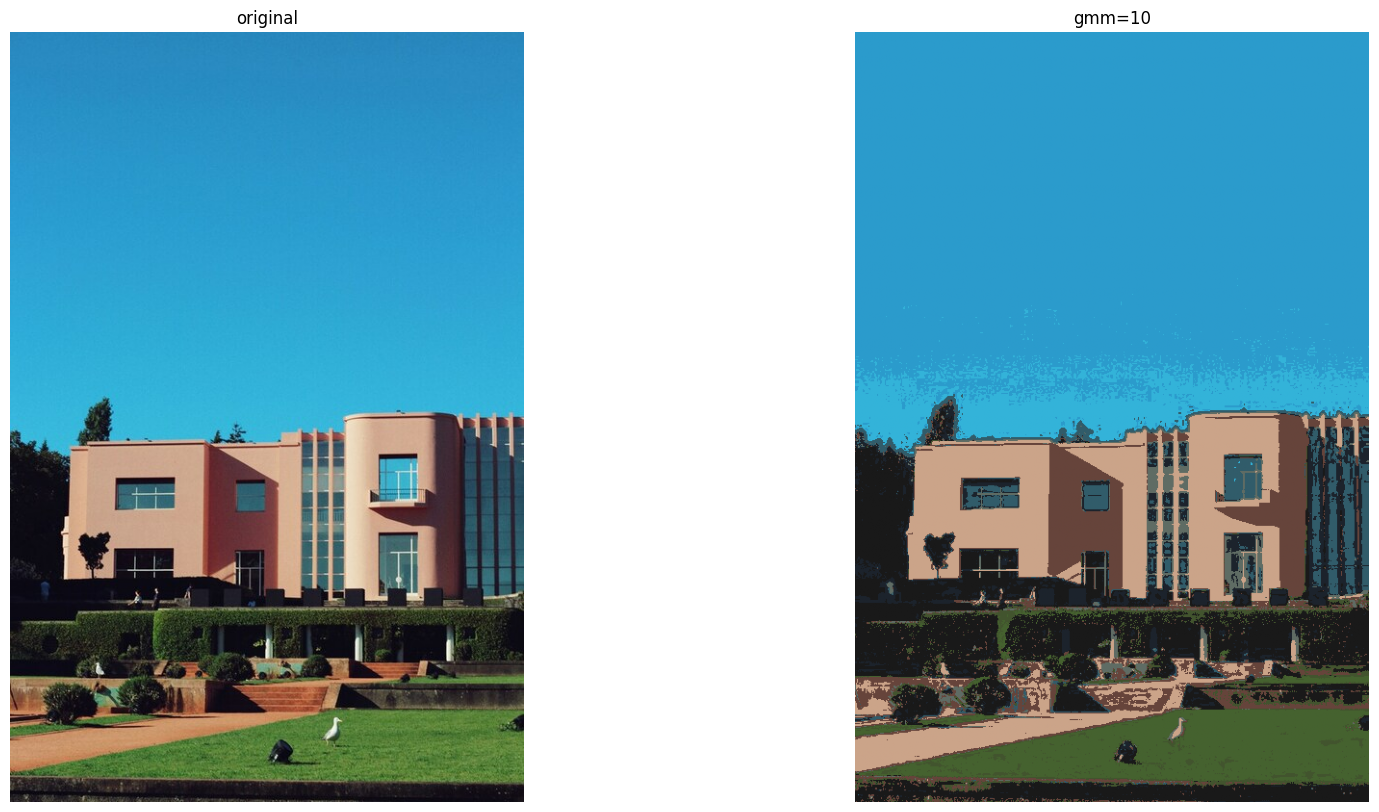

iter 9, loss: 4664662.3019: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


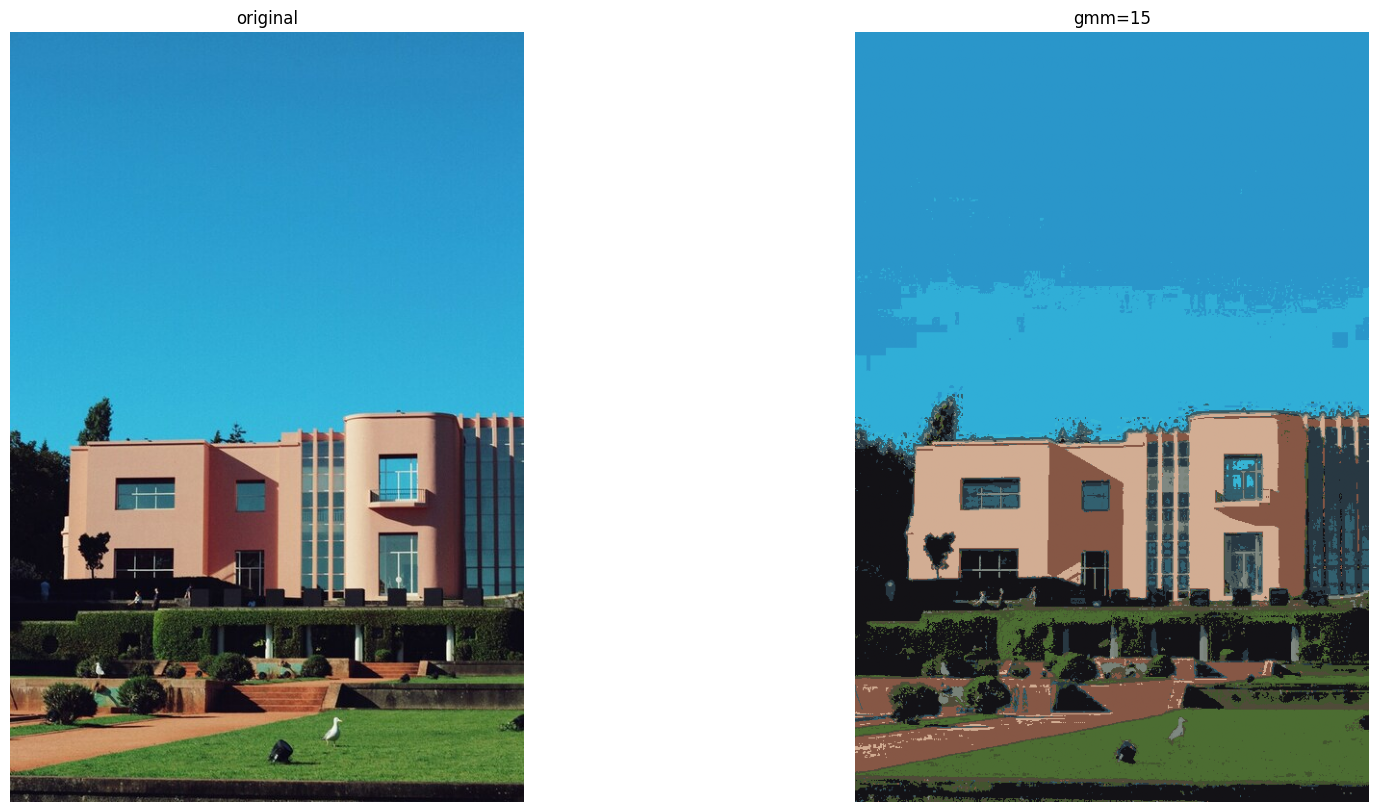

/var/folders/nw/q2mn_x1977g_6z8gkpznh84r0000gp/T/ipykernel_13409/578079728.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(img2_dir)
iter 9, loss: 4867629.0771: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


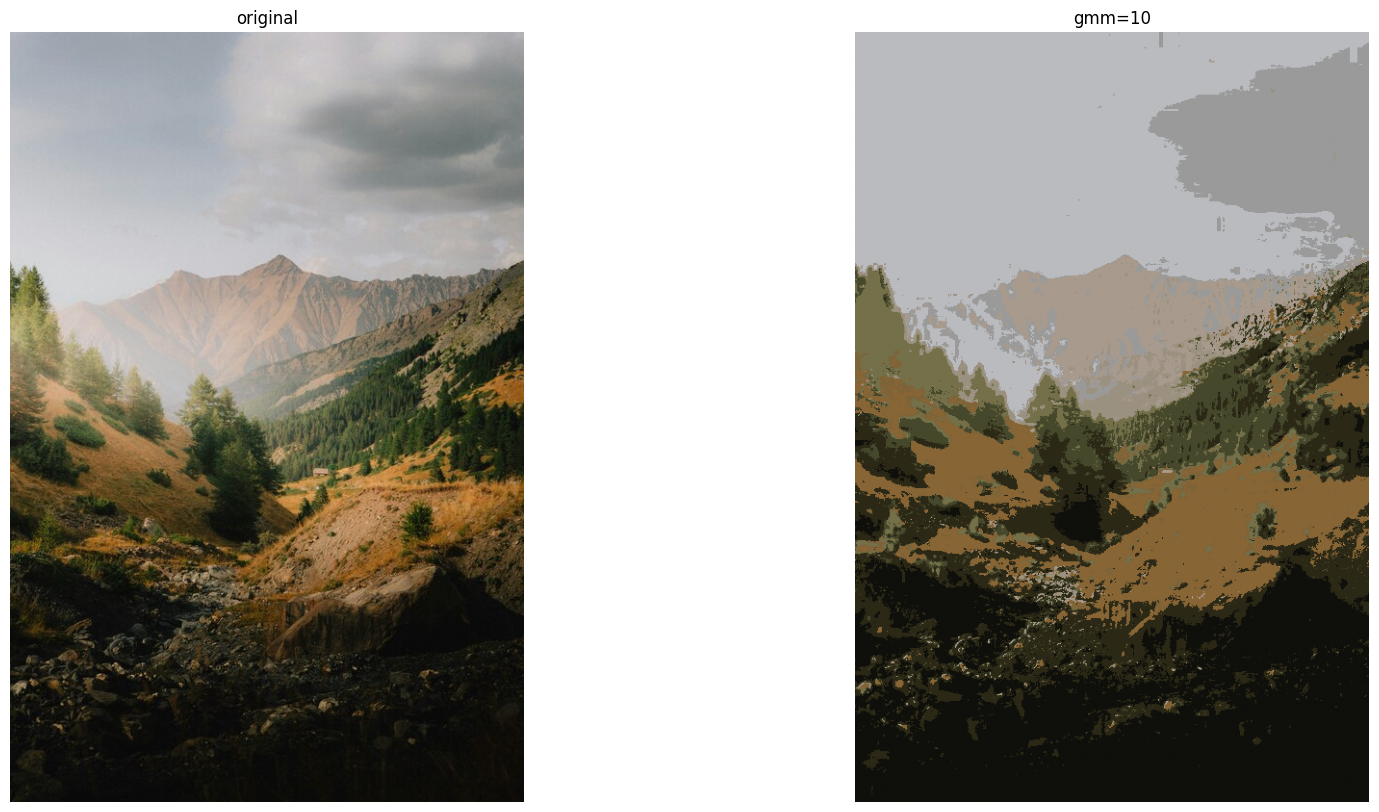

iter 9, loss: 4872330.5787: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


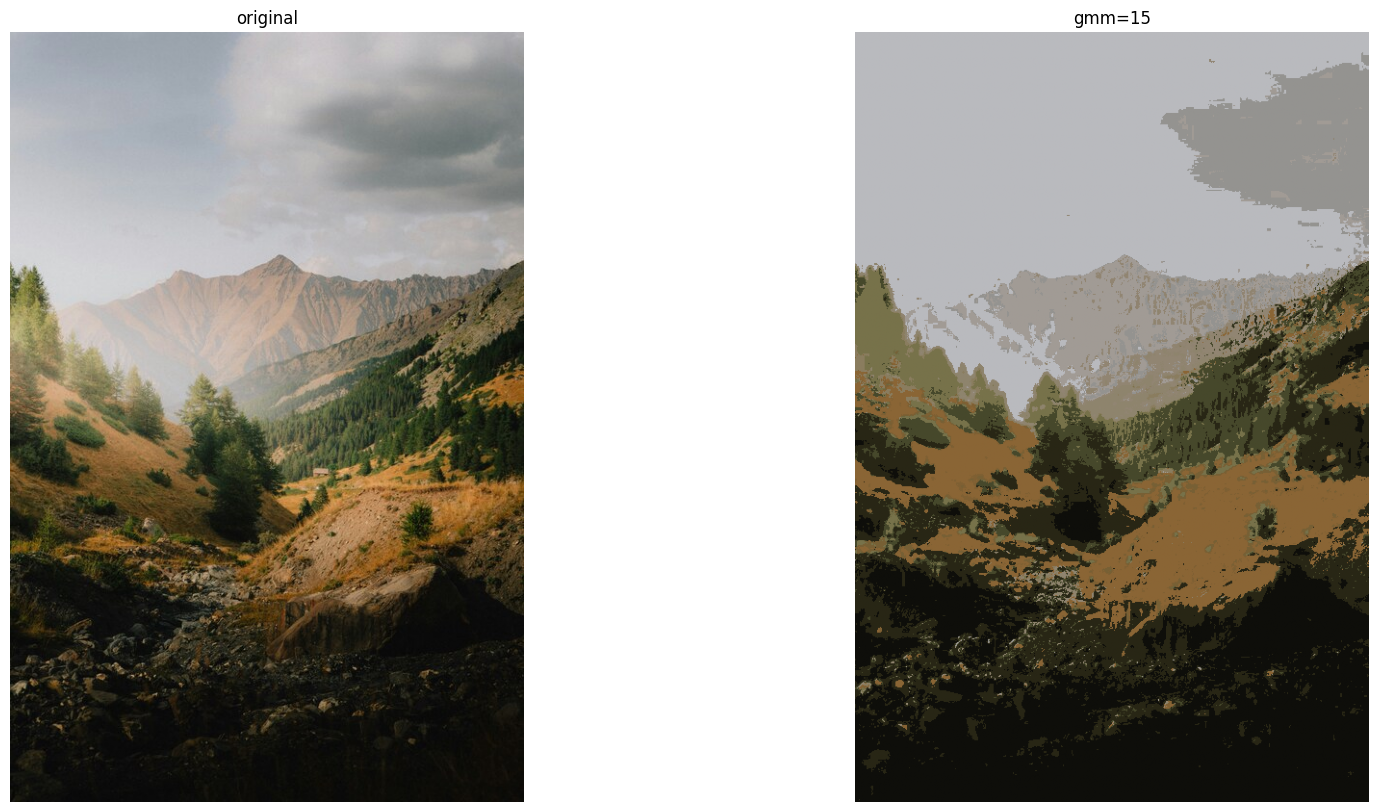

In [141]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

img1_dir = "./data/images/image_test_1.jpg"
img2_dir = "./data/images/image_test_2.jpg"

def perform_compression(image, min_clusters=10, max_clusters=20):
    for K in range(min_clusters, max_clusters + 1, 5):
        gmm_image_k = cluster_pixels_gmm(image, K, max_iters=10, full_matrix=True)
        plot_images([image, gmm_image_k], ["original", "gmm=" + str(K)])

image1 = imageio.imread(img1_dir)
perform_compression(image1, 10, 15)

image2 = imageio.imread(img2_dir)
perform_compression(image2, 10, 15)

## 3.4 Compare full covariance matrix with diagonal covariance matrix [1% Bonus for All]

Compare the results of clustering an image with full covariance matrix and diagonal covariance matrix. Can you explain why the images are different with same clusters?
Note: You will have to implement both multinormalPDF and normalPDF, and add a few arguments in the original \_ll_joint(), \_M_step(), \_E_step() function. **You will earn full credit only if you implement all functions AND provide an explanation.**


In [142]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################


def compare_matrix(image, K):
    """
    Args:
        image: input image of shape(H, W, 3)
        K: number of components

    Return:
        plot: comparison between full covariance matrix and diagonal covariance matrix.
    """
    # full covariance matrix
    gmm_image_full = cluster_pixels_gmm(image, K, 10, full_matrix=True)
    # diagonal covariance matrix
    gmm_image_diag = cluster_pixels_gmm(image, K, 10, full_matrix=False)

    plot_images(
        [gmm_image_full, gmm_image_diag],
        ["full covariance matrix", "diagonal covariance matrix"],
    )

iter 9, loss: 4830748.7887: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


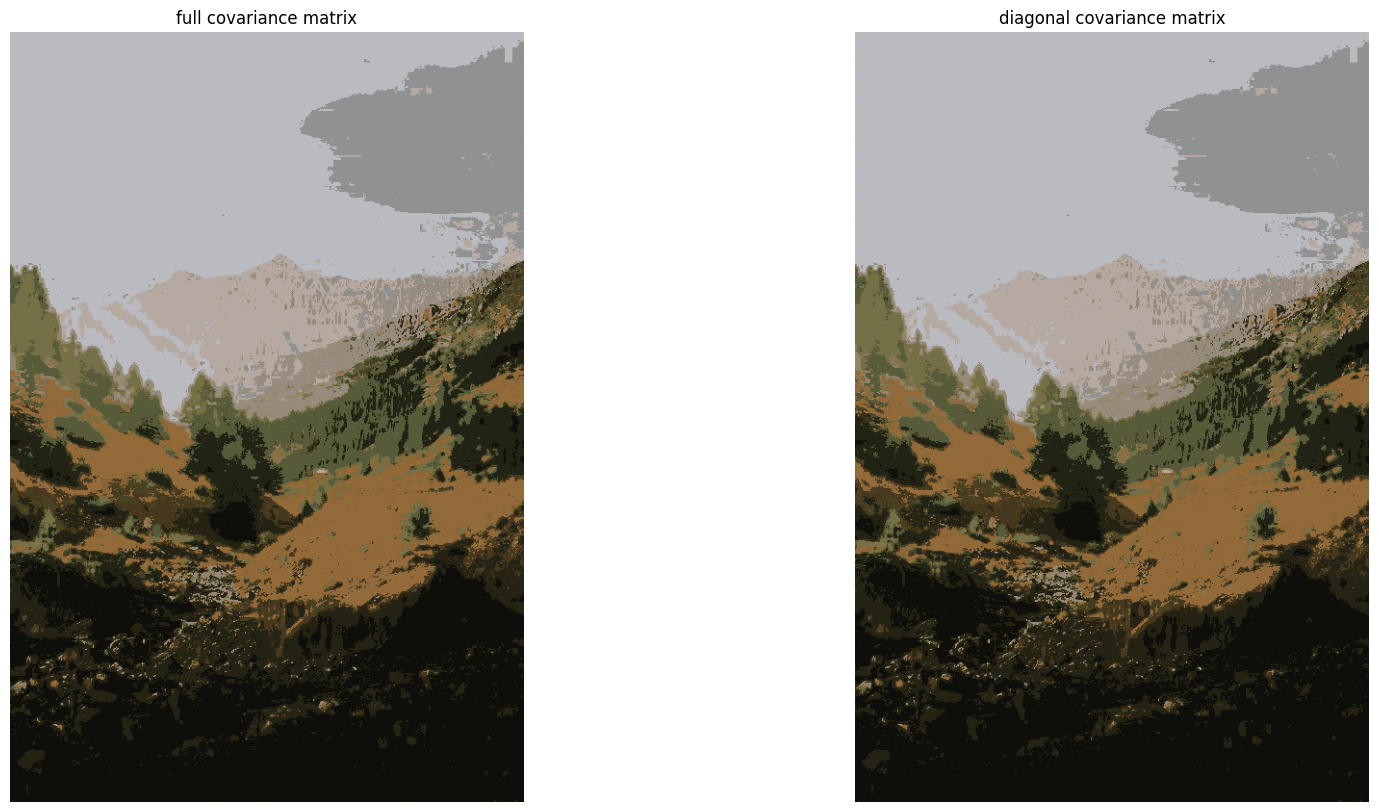

In [143]:
compare_matrix(image2, 20)

### Explanation of the difference between full covariance and diagonal covariance matrices

The primary difference between these two images lies in how the covariance matrices capture the relationships between features (in this case, pixel intensities across color channels).

#### 1. **Full Covariance Matrix:**
In a **full covariance matrix**, the model captures the correlation between different features (color channels in this case). This means that for each cluster, the covariance matrix allows the variation in one feature to be dependent on the others. Essentially, the shape of the Gaussian distribution for each cluster is more flexible and can take on any elliptical shape.

- In this image, using a full covariance matrix allows the clusters to model the data more accurately by considering interactions between different color channels.
- The resulting clustering is smoother and better captures the natural structure of the image.

#### 2. **Diagonal Covariance Matrix:**
In a **diagonal covariance matrix**, we assume that the features (color channels) are independent. The off-diagonal terms in the covariance matrix, which represent the covariances between different features, are zero. Each cluster is modeled with independent variances along each axis (color channel), which results in a simpler model. 

- The result is that each cluster can only take the shape of an axis-aligned ellipse or sphere in the feature space.
- In this image, the clustering with a diagonal covariance matrix is less flexible, and some of the subtleties in the color interactions may be missed, resulting in a more pixelated or less smooth appearance.

#### 3. **Why the Images are Different:**
The main reason for the differences is that the full covariance matrix captures complex relationships between the different features (color channels), while the diagonal covariance matrix does not. In image data, especially with RGB channels, the pixel intensities across the channels can be highly correlated. By using a full covariance matrix, we can capture these correlations, leading to better-defined clusters and smoother transitions between regions of the image.

On the other hand, with a diagonal covariance matrix, the clusters are constrained to model each color channel independently, which can result in less accurate clustering and more abrupt changes in color between clusters.

Thus, the difference in clustering quality arises from the flexibility and expressiveness of the covariance matrix. The full covariance matrix can capture more intricate relationships, while the diagonal covariance matrix simplifies the model, making it less capable of handling these complexities.


## 3.5 Generate samples from a Gaussian Mixture [5pts]


In this question, you will be fitting your GMM implementation on a 2D Gaussian Mixture to estimate the parameters of the distributions that make up the mixture, and then using these estimated parameters to generate samples.


(800, 2)


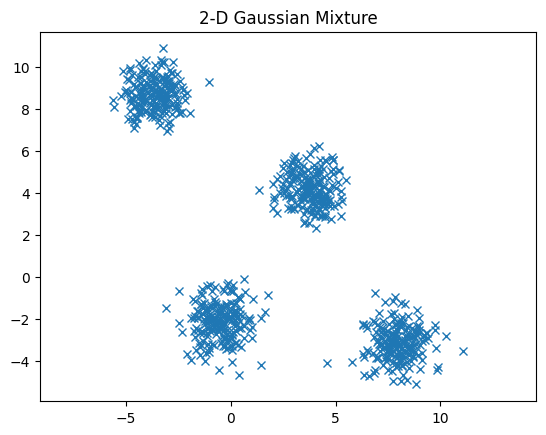

In [144]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

data = np.load("./data/gaussian_clusters.npy")
print(data.shape)

plt.plot(data[:, 0], data[:, 1], "x")
plt.axis("equal")
plt.title("2-D Gaussian Mixture")
plt.show()

Now, you need to estimate the parameters of the Gaussian Mixture, and then use these estimated parameters to generate 1000 samples from the Gaussian Mixture. Plot the sampled datapoints. **You should notice that it resembles the original Gaussian Mixture.**

**Steps**

- First, to estimate the parameters of the Gaussian Mixture, you'll need to fit your GMM implementation to the dataset. You need to specify K=4 to represent 4 gaussians in our model, and run the EM algorithm. You'll have to choose the value for max_iters. If at the end of this section, your plot of the sampled datapoints doesn't look like the original distribution, you may need to increase max_iters to fit the GMM model better, and obtain better estimates of the parameters.
- Once you heve the estimated parameters, we'll need to sample 1000 datapoints from the Gaussian Mixture. You will be using a technique called Rejection Sampling discussed below. Here are some external sources that may help: https://cosmiccoding.com.au/tutorials/rejection_sampling, https://towardsdatascience.com/rejection-sampling-with-python-d7a30cfc327b
  - We will be taking the approach from the first link, but extending it into the 2D space.
- The formula for the density function is $f(x_i) = \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)$


**Generating vs Sampling**
To generate points directly from a given distribution is done via Inverse transform sampling. In inverse transform sampling, we require taking the inverse of cummulative distribution function for our gaussian mixture model. This operation in general can be expensive unless there is some known formula for inverting the CDF. It is also not always possible to take the inverse of the CDF of a gaussian mixture model. For these reasons we will implement a sampling method instead. This sampling method will give us points matching the gmm without the computation and mathematical concerns of generation.

**Rejection Sampling**

Conventionally we think of Gaussian Mixture Models as a form of soft clustering, but you can also think of them as an algorithm for estimating density of data points with gaussians. Thus we can take an arbitary data point and using the gaussian mixture model as an estimation for the density at a given location. From here we want the points that we sample to be proportional to the density at a given location.

We go about this by, choosing an arbitary point (x,y). Then we use the density formula function $f(x_i) = \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)$ to find out what the density of points is at (x,y). Now that we have the density, we can draw a random number between 0 and the maximum density to determine if we will keep or discard (x,y). If the random number drawn is less than the density, then (x,y) is our sample, otherwise we discard (x,y) and repeat. This method ensure that the samples we generate are proportional to the density predicted by our GMM at any given area.


In [145]:
# Fit your GMM model here:
from gmm import GMM, cluster_pixels_gmm
from utilities import plot_images

gmm = GMM(data, 4, 20)
tau, (pi, mu, sigma) = gmm(full_matrix = True)

iter 13, loss: 3020.8639:  70%|███████   | 14/20 [00:00<00:00, 1236.97it/s]


In [146]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

# Extract x and y
x = data[:, 0]
y = data[:, 1]

# Define the borders of the grid
deltaX = (max(x) - min(x)) / 10
deltaY = (max(y) - min(y)) / 10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# coordinates of the points that make the grid
positions = np.vstack([xx.ravel(), yy.ravel()]).T

In [147]:
def density(points, pi, mu, sigma, gmm):
    """Evaluate the density at each point on the grid.
    Args:
        points: (N, 2) numpy array containing the coordinates of the points that make up the grid.
        pi: (K,) numpy array containing the mixture coefficients for each class
        mu: (K, D) numpy array containing the means of each cluster
        sigma: (K, D, D) numpy array containing the covariance matrixes of each cluster
        gmm: an instance of the GMM model

    Return:
        densities: (N, ) numpy array containing densities at each point on the grid

    HINT: You should be using the formula given in the hints.
    """
    # TODO: Implement this function   
    densities = np.zeros(points.shape[0])
        
    for i in range(points.shape[0]):
        for j in range(pi.shape[0]):
            diff = points[i] - mu[j]  
            sig_inv = np.linalg.inv(sigma[j]) 
            exponent = -0.5 * diff.T @ sig_inv @ diff  
            norm = np.sqrt((2 * np.pi) ** mu.shape[1] * np.linalg.det(sigma[j])) 
            densities[i] += pi[j] * np.exp(exponent) / norm

    return densities


# get the density at each coordinate on the grid
densities = np.reshape(density(positions, pi, mu, sigma, gmm), xx.shape)

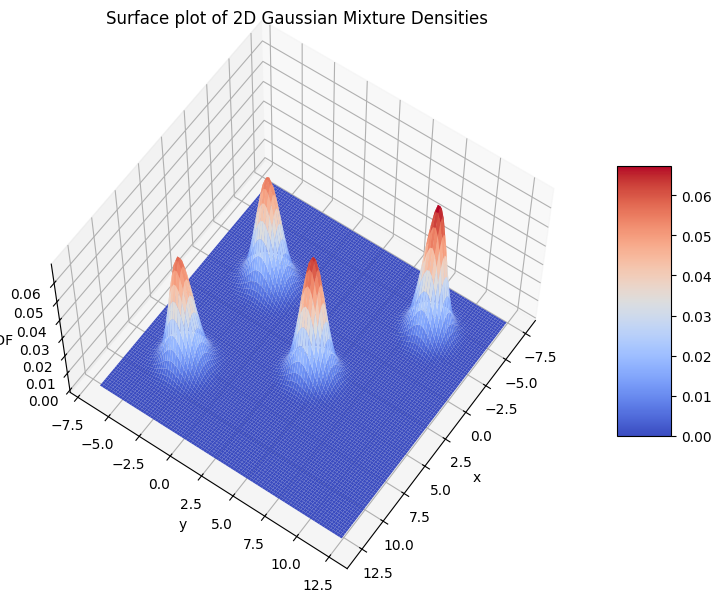

In [148]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

fig = plt.figure(figsize=(13, 7), dpi=100)
ax = plt.axes(projection="3d")
surf = ax.plot_surface(
    xx, yy, densities, rstride=1, cstride=1, cmap="coolwarm", edgecolor="none"
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("PDF")
ax.set_title("Surface plot of 2D Gaussian Mixture Densities")
fig.colorbar(surf, shrink=0.5, aspect=5)  # add color bar indicating the PDF
ax.view_init(60, 35)
plt.show()

In [149]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################


def rejection_sample(xmin, xmax, ymin, ymax, gmm, dmax=1, M=0.1):
    """Performs rejection sampling. Keep sampling datapoints until d <= f(x, y) / M
    Args:
        xmin: lower bound on x values
        xmax: upper bound on x values
        ymin: lower bound on y values
        ymax: upper bound on y values
        gmm: an instance of the GMM model
        dmax: the upper bound on d
        M: scale_factor. can be used to control the fraction of samples that are rejected

    Return:
        x, y: the coordinates of the sampled datapoint

    HINT: Refer to the links in the hints
    """
    while True:
        x = np.random.uniform(low=xmin, high=xmax)
        y = np.random.uniform(low=ymin, high=ymax)
        d = np.random.uniform(low=0, high=dmax)
        if d < density(np.array([x, y]).reshape(1, 2), pi, mu, sigma, gmm) / M:
            return x, y

In [150]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################


# Sample datapoints using Rejection Sampling
generated_datapoints = np.zeros((1000, 2))
i = 0
while i < 1000:
    generated_datapoints[i, 0], generated_datapoints[i, 1] = rejection_sample(
        xmin, xmax, ymin, ymax, gmm, dmax=1
    )
    if i % 100 == 0:
        print(i)
    i += 1

0
100
200
300
400
500
600
700
800
900


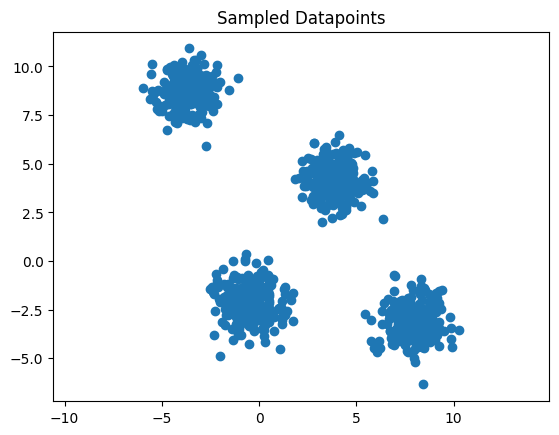

In [151]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

plt.scatter(generated_datapoints[:, 0], generated_datapoints[:, 1])
plt.axis("equal")
plt.title("Sampled Datapoints")
plt.show()

## 4. (Bonus for All) Cleaning Messy data and semi-supervised learning [8% Bonus for All]

Learning to work with messy data is a hallmark of a well-rounded data scientist. In most real-world settings the data given will usually have some issue, so it is important to learn skills to work around such impasses. This part of the assignment looks to expose you to clever ways to fix data using concepts that you have already learned in the prior questions.

#### Question

Congratulations! you recently graduated with your shiny GT degree. You've decided to pursue your childhood dream to study astrophysics. Stationed at a cutting edge Gamma Ray Telescope facility as a Data Scientist, delving into the high-energy physics of the universe, your mission is to probe the enigmatic Sagittarius A*, the supermassive black hole in the center of our galaxy, using a telescope that views the cosmos through gamma rays emitted by the most cataclysmic events in space like neutron star mergers, pulsars, and the voracious accretion disks of black holes. SUPER EXCITING!

The cutting edge telescope you are working with detects these really high energy gamma ray emissions from really small windows in the sky. You find that the telescope can be configured with a few parameters to detect these particles. These parameters, 10 in number, range from the telescope's orientation and timing precision to the sensitivity settings that find the faintest gamma signals against the cosmic background.

However, your cosmic quest faces an unexpected challenge. A data corruption incident has left a 15% void across your dataset, affecting both the intricate telescope parameters and the critical gamma ray detection records. This isn't just a minor hiccup; it's a significant obstacle in your path to unraveling the mysteries of our galaxy's heart.

But there's a silver lining. You remember that the machine learning techniques learnt in CS4641/7641 are the key to navigating this data loss issue. This challenge transforms into an opportunity to showcase the resilience and ingenuity of data science in the face of adversity. How will you leverage your skills to reconstruct the missing pieces and ensure that your exploration of Sagittarius A* yields groundbreaking insights into the universe's most profound secrets?

Task: 
Clean the data and implement a semi-supervised learning framework to classify the detection of gamma rays for your experiments. The data has 10 feature columns containing the telescope's parameters and one column containing a binary label containing either (0 or 1) representing the absence or a presence of a signal.

You are given two files for this task:

- data.csv: the entire dataset with complete and incomplete data
- validation.csv: a smaller, fully complete dataset made after the intern deleted the datapoints






### 4.1 Data Cleaning [2.8%]

### 4.1.a Data Separating [0.7%]

The first step is to break up the whole dataset into clear parts. All the data is randomly shuffled in one csv file. In order to move forward, the data needs to be split into three separate arrays:

- labeled_complete: containing the complete characterization data and corresponding labels
- labeled_incomplete: containing partial characterization data (i.e., one of the features is NaN) and corresponding labels
- unlabeled_complete: containing complete characterization data but no corresponding labels (i.e., the label is NaN)

In **semisupervised.py**, implement the following methods:

- complete\_
- incomplete\_
- unlabeled\_


<img src="data/images/dirty_dataset_example.png" width="1000">


In [152]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

localtests.SemisupervisedTests().test_data_separating_methods()

UnitTest passed successfully!


### 4.1.b KNN [1.4%]

The second step in this task is to clean the Labeled_incomplete dataset by filling in the missing values with probable ones derived from complete data. A useful approach to this type of problem is using a [k-nearest neighbors (k-NN) algorithm](https://www.freecodecamp.org/news/k-nearest-neighbors-algorithm-classifiers-and-model-example/). For this application, the method consists of replacing the missing value of a given point with the mean of the closest k-neighbors to that point. Given that you are focusing on neighbouring points, the margin of error from actual missing values should be limited.

In the **CleanData** class in **semisupervised.py**, implement the following methods:

- pairwise_dist
- \_\_call\_\_


The unit test is a good expectation of what the process should look like on a toy dataset. If your output matches the answer, you are on the right track. Run the following cell to check.

NOTE: Your rows of data should match with the expected output, although the order of the rows does not necessarily matter.


In [153]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

localtests.SemisupervisedTests().test_cleandata()

UnitTest passed successfully!


### 4.1.c Median of Features [0.7%]

Another method of filling the missing values is by using the median of individual features. Our goal with replacing NaN values is to insert values in their place while also minimally disturbing the overall distribution of each feature. Using the median of features helps avoid drastically changing the distribution of our data. This is also why while we could technically replace NaN values with 0, it is generally not advised to do so.

Implement the median_clean_data method in accordance with this rule.
NOTE: There should be no NaN values in the n\*d array that you return from median_clean_data.

In **semisupervised.py**, implement the following method:

- median_clean_data


In [154]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

localtests.SemisupervisedTests().test_median_clean_data()

UnitTest passed successfully!


### 4.2 Semi-supervised Learning [3.5%]

### 4.2.a Getting acquainted with semi-supervised learning approaches. [1.2%]

Take a look at the algorithm presented in Table 1 of the paper ["Text Classification from Labeled and Unlabeled Documents using EM"](http://www.kamalnigam.com/papers/emcat-mlj99.pdf) by Nigam et al. (2000). While you are recommended to read the whole paper this assignment focuses on items 5.1, 5.2, and 6.1. Write a brief summary of three interesting highlights of the paper (50-words maximum).

Summary of 3 intersting highlights:
1. The EM algorithm combines labeled and unlabeled data. This improves text classification by up to 30% mainly with limited labeled data.
2. Using EM reduces the need for labeled data and achieving similar accuracy with fewer labeled examples.
3. Extensions to the algorithm like dynamic weighting and mixture components per class address limitations in real-world data classification.


### 4.2.b Implementing the EM algorithm. [2.3%]

Implement the EM algorithm proposed by Nigam et al. (2000) on Table 1, using a Gaussian Naive Bayes (GNB) classifier instead of a Naive Bayes (NB) classifier. What's the difference between the way of initialization in the paper and the way introduced in class?

(Hint: Using a GNB in place of an NB will enable you to reuse most of the implementation you developed for GMM in this assignment. In fact, you can successfully solve the problem by simply modifying the call and \_init_components methods.)

In the **SemiSupervised** class in **semisupervised.py**, implement the following methods:

- \_init_components
- \_\_call\_\_


### 4.3 Demonstrating the performance of the algorithm. [1.1%]

Compare the classification error based on the Gaussian Naive Bayes (GNB) classifier you implemented following the Nigam et al. (2000) approach to the performance of a GNB classifier trained using only labeled data. Since you have not covered supervised learning in class, you are allowed to use the scikit learn library for training the GNB classifier based only on labeled data: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html.

In the **ComparePerformance** class in **semisupervised.py**, implement the following method:

- accuracy_semi_supervised
- accuracy_GNB

To acheive the full 5 points you must implement the `ComparePerformance.accuracy_semi_supervised` and `ComparePerformance.accuracy_GNB` methods and get these scores:

- accuracy_complete_data_only > 71%
- accuracy_cleaned_data > 71%
- accuracy_semi_supervised > 69%


In [155]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################
from semisupervised import (
    CleanData,
    ComparePerformance,
    complete_,
    incomplete_,
    median_clean_data,
    unlabeled_,
)

In [156]:
###############################
### DO NOT CHANGE THIS CELL ###
###############################

# Load training data
all_data = np.loadtxt("data/data.csv", delimiter=",")

# Separate training data into categories: labeled complete, labeled incomplete, and unlabeled points
labeled_complete = complete_(all_data)
labeled_incomplete = incomplete_(all_data)
unlabeled = unlabeled_(all_data)

# Perform data cleaning on labeled incomplete data
cleaned_data = CleanData()(labeled_incomplete, labeled_complete, 10)

# Combine cleaned data with unlabeled data
cleaned_and_unlabeled = np.concatenate((cleaned_data, unlabeled), 0)

# Category for data that is guaranteed to have label values
labeled_data = np.concatenate((labeled_complete, labeled_incomplete), 0)

# Perform median data cleaning on all labeled data
median_cleaned_data = median_clean_data(labeled_data)

# Print data shapes
print(f"All Data shape:                 {all_data.shape}")
print(f"Labeled Complete shape:         {labeled_complete.shape}")
print(f"Labeled Incomplete shape:       {labeled_incomplete.shape}")
print(f"Labeled shape:                  {labeled_data.shape}")
print(f"Unlabeled shape:                {unlabeled.shape}")
print(f"Cleaned data shape:             {cleaned_data.shape}")
print(f"Cleaned + Unlabeled data shape: {cleaned_and_unlabeled.shape}")

# load validation data
validation = np.loadtxt("data/validation.csv", delimiter=",")

# =========================================================================
# SUPERVISED GNB WITH ONLY THE COMPLETE DATA (SKLEARN)
accuracy_complete_data_only = ComparePerformance.accuracy_GNB(
    labeled_complete, validation
)
# =========================================================================
# SUPERVISED GNB WITH CLEAN DATA (SKLEARN)
accuracy_cleaned_data = ComparePerformance.accuracy_GNB(cleaned_data, validation)
# =========================================================================
# SUPERVISED GNB WITH MEDIAN CLEAN DATA (SKLEARN)
accuracy_median_cleaned_data = ComparePerformance.accuracy_GNB(
    median_cleaned_data, validation
)
# =========================================================================
# SEMI SUPERVISED GNB WITH ALL DATA (your implementation)
accuracy_semi_supervised = ComparePerformance.accuracy_semi_supervised(
    cleaned_and_unlabeled, validation, 2
)
# ==========================================================================
# COMPARISON
print("""===COMPARISON===""")
print(
    f"Supervised with only complete data, GNB Accuracy: {np.round(100.0 * accuracy_complete_data_only, 3)}%"
)
print(
    f"Supervised with KNN clean data, GNB Accuracy:     {np.round(100.0 * accuracy_cleaned_data, 3)}%"
)
print(
    f"Supervised with Median clean data, GNB Accuracy:    {np.round(100.0 * accuracy_median_cleaned_data, 3)}%"
)
print(
    f"SemiSupervised Accuracy:                          {np.round(100.0 * accuracy_semi_supervised, 3)}%"
)

All Data shape:                 (19020, 11)
Labeled Complete shape:         (16167, 11)
Labeled Incomplete shape:       (2621, 11)
Labeled shape:                  (18788, 11)
Unlabeled shape:                (232, 11)
Cleaned data shape:             (18788, 11)
Cleaned + Unlabeled data shape: (19020, 11)
===COMPARISON===
Supervised with only complete data, GNB Accuracy: 72.275%
Supervised with KNN clean data, GNB Accuracy:     72.35%
Supervised with Median clean data, GNB Accuracy:    72.3%
SemiSupervised Accuracy:                          77.475%


### 4.4 Interpretation of Results. [0.6%]

What are the differences in using the kNN method and the median method to fill NaN values? Explain in terms of the results you get from each. What would be some advantages of using the median method to fill in NaN values over using the **mean** of features?









The results highlight small differences in performance between the kNN and median methods for handling NaN values. Specifically, the GNB accuracy after using the kNN method was 72.35%, while the median method resulted in 72.3%. The kNN method performs slightly better because it estimates missing values based on the nearest neighbors, considering local patterns in the data. This approach allows kNN to capture relationships between features, which can lead to more accurate predictions when the data has underlying structures or clusters.

In contrast, the median method replaces NaN values with the median of the feature across the dataset. This method is faster and computationally simpler, as it doesn't rely on finding relationships between the data points. However, the trade-off is that it might miss important patterns that kNN can capture, especially in complex datasets where feature interactions play a role in prediction accuracy. Despite this, the difference in accuracy is quite small, indicating that for simpler or more homogeneous data, the median method can perform nearly as well as kNN.

One advantage of the median method over the mean is its robustness to outliers. The mean can be skewed by extreme values, resulting in biased estimates for missing data. The median, on the other hand, reflects the central tendency of the data without being influenced by outliers, making it a more reliable choice in datasets with skewed distributions. This advantage helps prevent the filling of NaN values from introducing additional noise into the model.


## 5. Evaluating Data Representation in K-Means Clustering  [4pts]

A national healthcare system employs a K-means clustering algorithm to optimize healthcare resource distribution. Two datasets are used: one from Harborview, an underdeveloped city, and another from Greenfield, a developed city. The algorithm is applied to both datasets to identify healthcare resource allocation needs.

Datasets from vastly different settings might differ in incidence of chronic conditions, or preventive care and better healthcare access. Compare the heatmaps below:

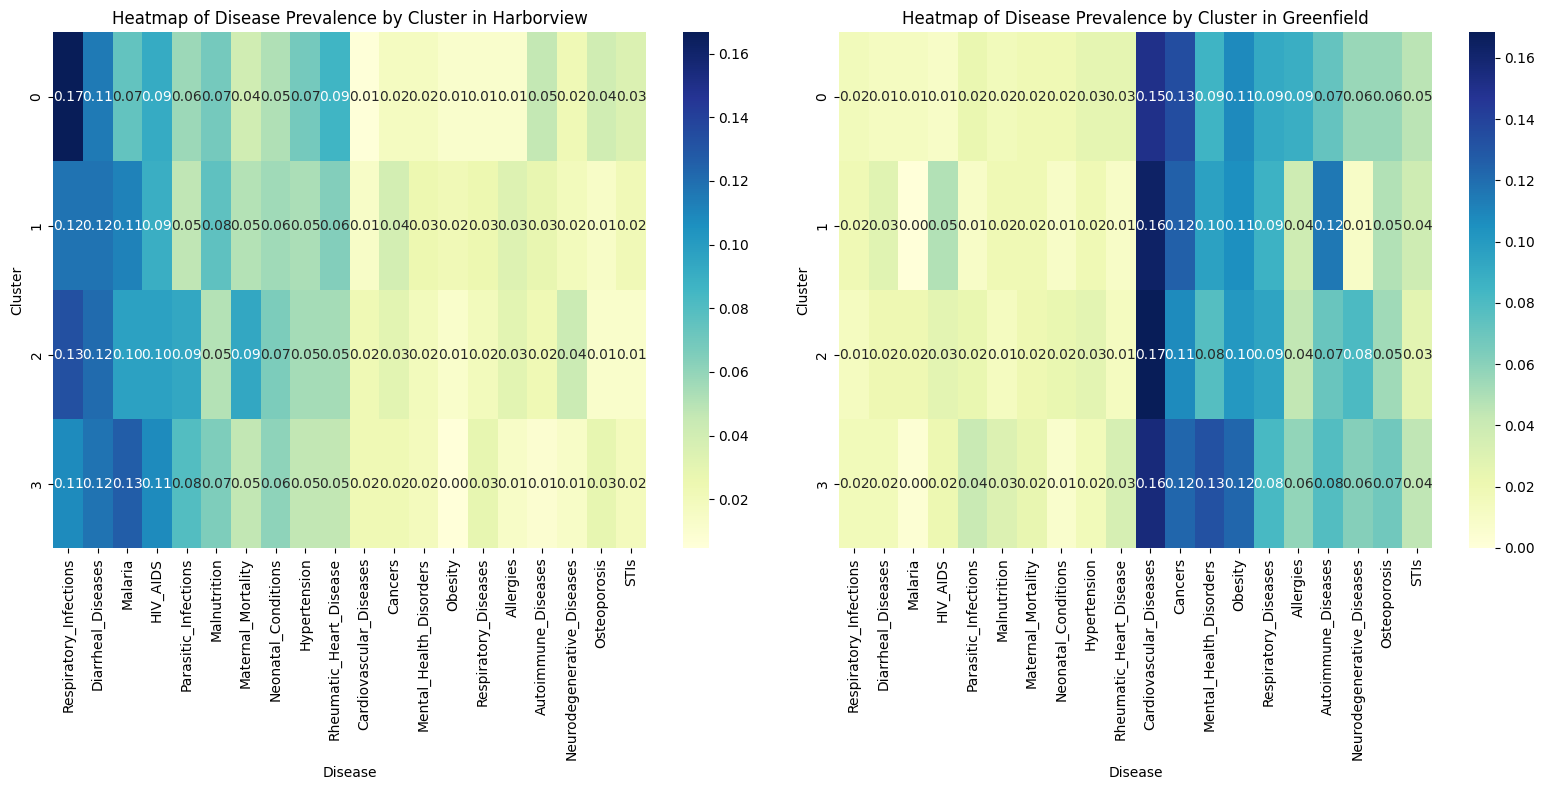

<Figure size 640x480 with 0 Axes>

In [157]:
%run Vis_DoNotChange.py

Question:  
Which of the following statements are correct? (Select all that apply)

- A. Sensitivity to the scale and scope of the data might result in the urgency of certain health conditions being overlooked.
- B. Uniform resource distribution between cities is the best ethical approach. 
- C. Concentrating on general data trends, the algorithm may overlook the specific healthcare needs of smaller, underrepresented groups.
- D. If data contains underrepresentation of certain demographic groups, existing disparities (as shown by the plot) might be magnified.
- E. The outputs of unsupervised algorithms like K-means clustering are inherently unbiased, as they do not rely on pre-labeled data.

**Answer** = A, C, D